This projects aims to create a detection fraud system using machine learning.

**dataset content**

**step** - unit of time (1 hour)

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

**amount** - transaction amount in local currency.

**nameOrig** - transaction originator

**oldbalanceOrg** - initial balance (before transaction)

**newbalanceOrig** - new balance (after transaction)

**nameDest** - transaction recipient

**oldbalanceDest** - initial balance before transaction.

**newbalanceDest** - new balance after transaction.

**isFraud** - Fraud agent takes control of customers accounts and attempts to empty it by transferring to another account and then cashing out.

**isFlaggedFraud** - An illegal attempt to transfer massive amount of money in a single transaction.


# Imports

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# data balancing
from imblearn.over_sampling import SMOTE
import os

# Get Data

In [2]:
# reading csv 
df = pd.read_csv('../data/raw/fraud_dataset.csv')

In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [67]:
# checking the columns names
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Bringing fraud columns to the beginning of the dataset

In [68]:
# reordering the columns
df = df[['isFraud','isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']]
df.head()

,isFraud,isFlaggedFraud,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Renaming columns

In [69]:
# creating dictionary containing columns names to change it
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [70]:
# renaming columns
df = df.rename(columns = colunas)
df.head()

,fraude,super_fraude,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Other dataset's informations

In [71]:
# analyzing main statistics
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
fraude,101613.0,0.00,0.03,0.00,0.00,0.00,0.00,1.00
super_fraude,101613.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tempo,101613.0,8.52,1.82,1.00,8.00,9.00,10.00,10.00
valor,101613.0,174090.07,345019.90,0.32,10016.59,53385.41,212498.40,10000000.00
saldo_inicial_c1,101613.0,907175.26,2829575.28,0.00,0.00,20190.47,194715.00,38939424.03
novo_saldo_c1,101613.0,923499.25,2867318.71,0.00,0.00,0.00,219217.76,38946233.02
saldo_inicial_c2,101613.0,881042.80,2399949.06,0.00,0.00,21058.00,591921.70,34008736.98
novo_saldo_c2,101613.0,1183998.10,2797761.08,0.00,0.00,51783.43,1063121.64,38946233.02


In [72]:
# columns and rows numbers 
df.shape

(101613, 11)

In [73]:
# looking for null values and its dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


# Verifying target variable

In [74]:
# agroupping the fraud label to discover its step
df2 = df.groupby(by = 'fraude').agg({'tempo':'count'}).reset_index()

# Calculating Percentage
df2['percent'] = ((df2['tempo'] / 
                  df2['tempo'].sum()) * 100).round(2)
# 
df2

,fraude,tempo,percent
0,0,101497,99.89
1,1,116,0.11


Only 0.11% of data comes from fraudlent transactions.

# Encoding

In [75]:
# transforming cathegorical data into numerical values
df = pd.get_dummies(data = df, columns = ['tipo'])

In [76]:
df.head()

,fraude,super_fraude,tempo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0
1,0,0,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0
2,1,0,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,0,0,0,1
3,1,0,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1,0,0,0
4,0,0,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0


# Removing variables

There's no super fraude, this column needs to be removed.

In [77]:
# dropping columns
df = df.drop(columns = ['cliente1', 'cliente2', 'super_fraude'])

In [78]:
df.head()

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


# Logistic Regression

In [27]:
# extracting the target variable from original dataframe
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [28]:
# splitting original dataframe into train data and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [29]:
# instantiating linear regression
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# training model
lr.fit(x_train, y_train)
# predicting label
y_pred = lr.predict(x_test)

# Model Metrics

In [30]:
# analyzing accuracy
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analyzing precision
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
# analyzing recall
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analyzing F1 score
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.9989765391276965
Precision: 0.2
Recall: 0.043478260869565216
F1 Score: 0.07142857142857142


# Confusion Matrix

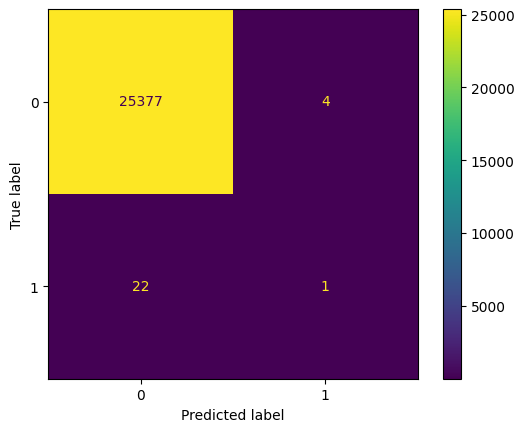

In [31]:
# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Classes are out of balance as there is much more data in a class (from those that did not fraud) compared to fraud occurrences.

# ROC Curve

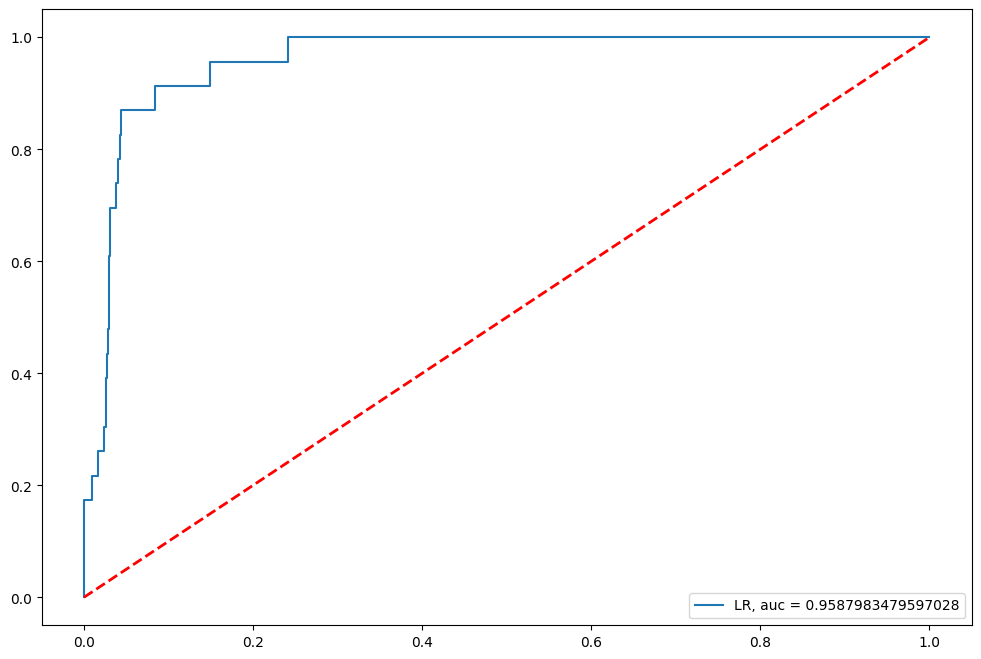

In [32]:
# instantiating ROC curve metrics
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plotting
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)

The ROC curve shows us unbalanced classes due to a very high accuracy, but the other metrics are very low. It's going to be necessary to balance the model.

# Balancing data

In [33]:
# instantiating smote
smote = SMOTE(random_state = 42)

In [34]:
# extracting the target variable from original dataframe
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [35]:
# creating balanced variables
x_resampled, y_resampled = smote.fit_resample(x, y)

In [36]:
# joining resampled data into unique dataframe
df_balanced = pd.concat([y_resampled, x_resampled], axis = 1)

In [37]:
df_balanced

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.640000,170136.000000,160296.36,0.000000,0.000000,0,0,0,1,0
1,0,1,1864.280000,21249.000000,19384.72,0.000000,0.000000,0,0,0,1,0
2,1,1,181.000000,181.000000,0.00,0.000000,0.000000,0,0,0,0,1
3,1,1,181.000000,181.000000,0.00,21182.000000,0.000000,0,1,0,0,0
4,0,1,11668.140000,41554.000000,29885.86,0.000000,0.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202989,1,5,17608.962863,17608.962863,0.00,0.000000,0.000000,0,0,0,0,1
202990,1,7,12116.291013,12116.291013,0.00,0.000000,0.000000,0,0,0,0,1
202991,1,1,231612.880715,231612.880715,0.00,1945.589357,9370.603471,0,0,0,0,0
202992,1,9,547325.144758,547325.144758,0.00,0.000000,0.000000,0,0,0,0,1


In [38]:
# agroupping fraud label to analyze its frequencies
df_balanced.groupby(by = 'fraude').agg({'tempo':'count'})

,tempo
fraude,
0,101497
1,101497


Now the target label is balanced

# A new test with Logistic Regression

In [41]:
# splitting dataframe
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [42]:
# splitting original dataframe into train data and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)

# instantiating linear regression
lr = LogisticRegression(max_iter=1000, random_state = 42)

# fitting model
lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)

# analyzing accuracy
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analyzing precision
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
# analyzing recall
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analyzing F1 score
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1 Score: 0.9428709521507975


Even though the accuracy decreased, the other metrics grew higher, which indicates a better result.

# Confusion Matrix and Roc Curve for balanced dataset model

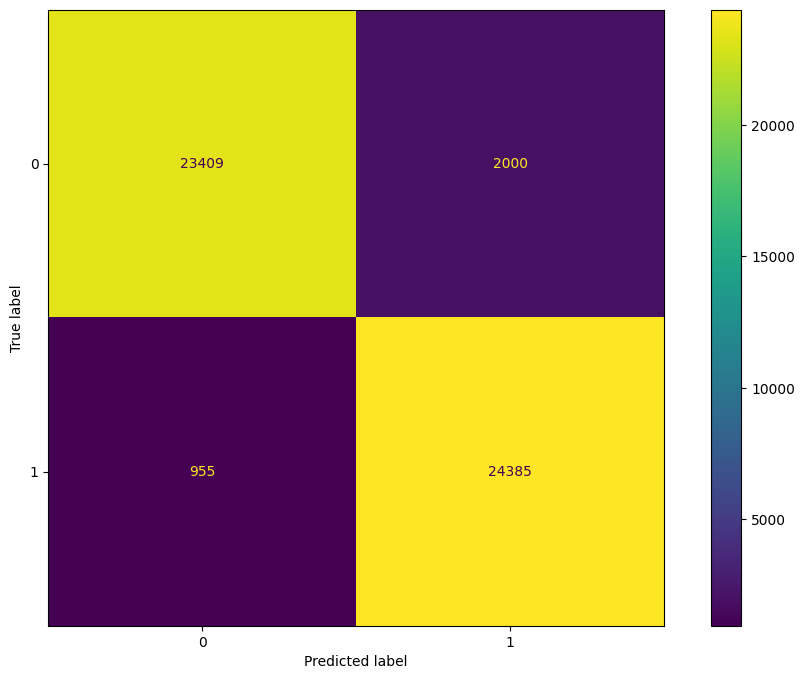

In [43]:
# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Text(0.5, 1.0, 'ROC Curve - Linear Regression')

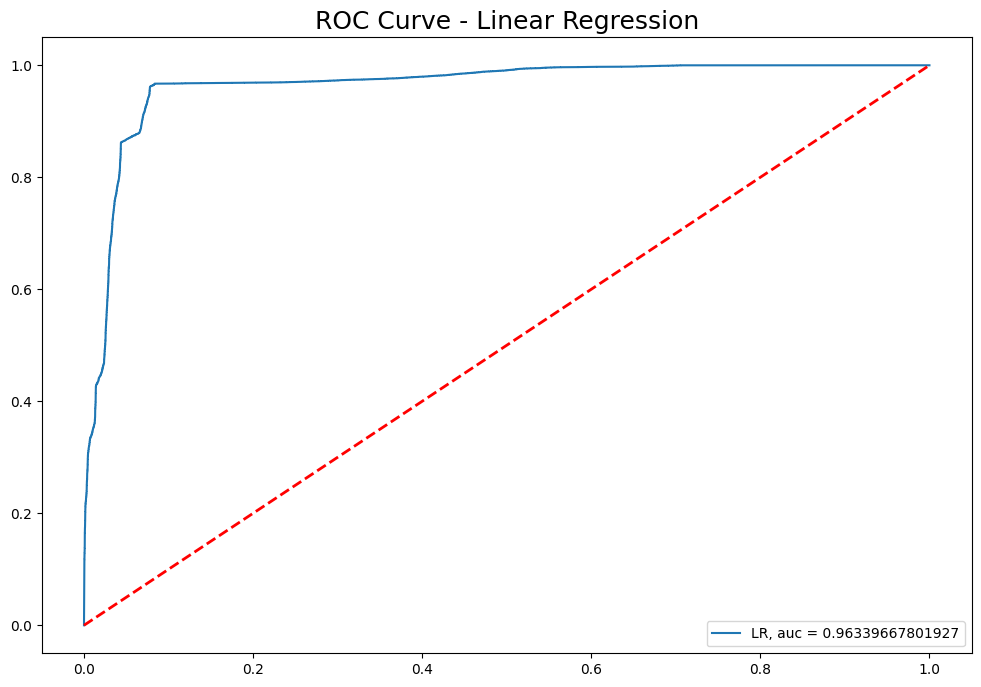

In [44]:
# instantiating ROC curve metrics
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plotting
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)
plt.title('ROC Curve - Linear Regression', fontsize = 18)

# Hypothesis of fraud

The target variable is highly correlated to novo_saldo_1, cash_in, payment and transfer, which gives us some hyphotesis:

* Hypothesis 1: The payment type is what the customers use as default and the fraud occurs through the transfer type.

* Hypothesis 2: The customer makes their payments during a period time and the fraud occurs at different periods.

* Hyphothesis 3: The customer pays its bills at the beginning of each month and there are transactions at the end of the month, are more likely to be a fraud.

# Decision Tree

## creating comparative models to the logistic regression

In [45]:
# instantiating decision tree
dt =  DecisionTreeClassifier(max_depth = 5, random_state = 42)

In [46]:
# training decision tree
model = dt.fit(x_train, y_train)
# prediction values
y_pred = dt.predict(x_test)

In [47]:
# analyzing accuracy
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analyzing precision
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
# analyzing recall
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analyzing F1 score
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1 Score: 0.9632432017206943


# Decision tree confusion matrix

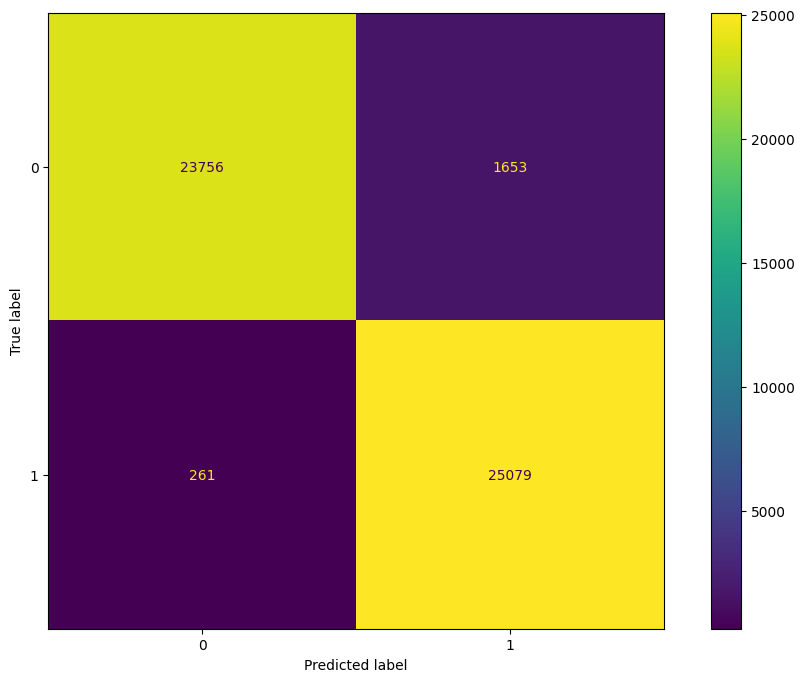

In [48]:
# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

The metrics results increased if compared to logistic regression.

# Decision tree ROC Curve

Text(0.5, 1.0, 'ROC Curve - Decision Tree')

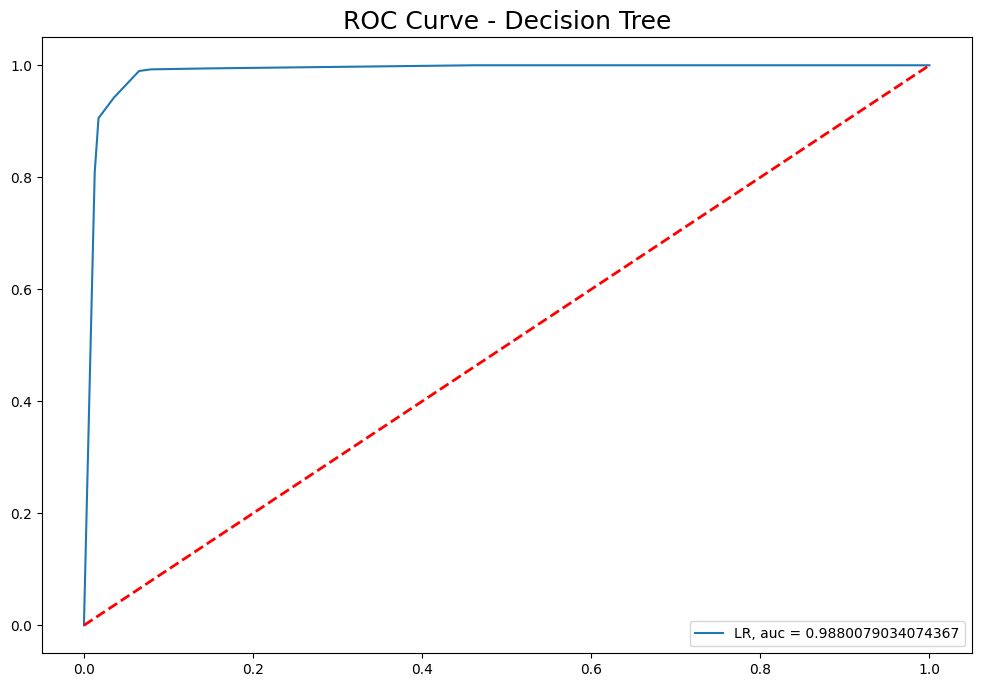

In [49]:
# instantiating ROC curve metrics
y_pred_proba = dt.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plotting
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)
plt.title('ROC Curve - Decision Tree', fontsize = 18)

# Random Forest

In [50]:
# instantiating random forest
rf = RandomForestClassifier(max_depth = 5, random_state = 42)

In [51]:
# training model
model = rf.fit(x_train, y_train)
# predicted label
y_pred = rf.predict(x_test)

# Random Forest Metrics

In [52]:
# analyzing accuracy
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analyzing precision
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
# analyzing recall
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analyzing F1 score
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1 Score: 0.9723896175509079


# Random Forest Confusion Matrix

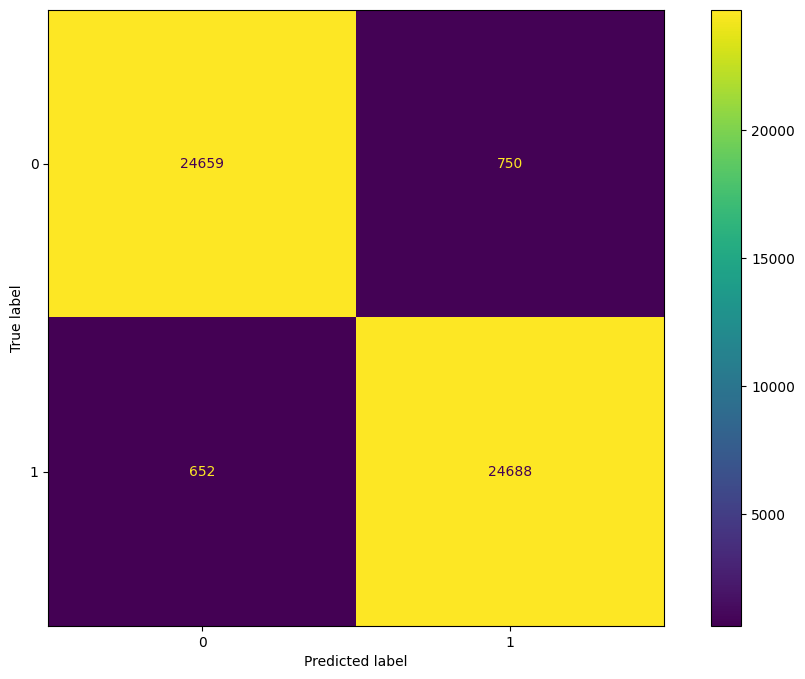

In [53]:
# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

The random forest algorithm shows a better performance regard the decision tree.

# Random Forest ROC Curve

Text(0.5, 1.0, 'ROC Curve - Random Forest')

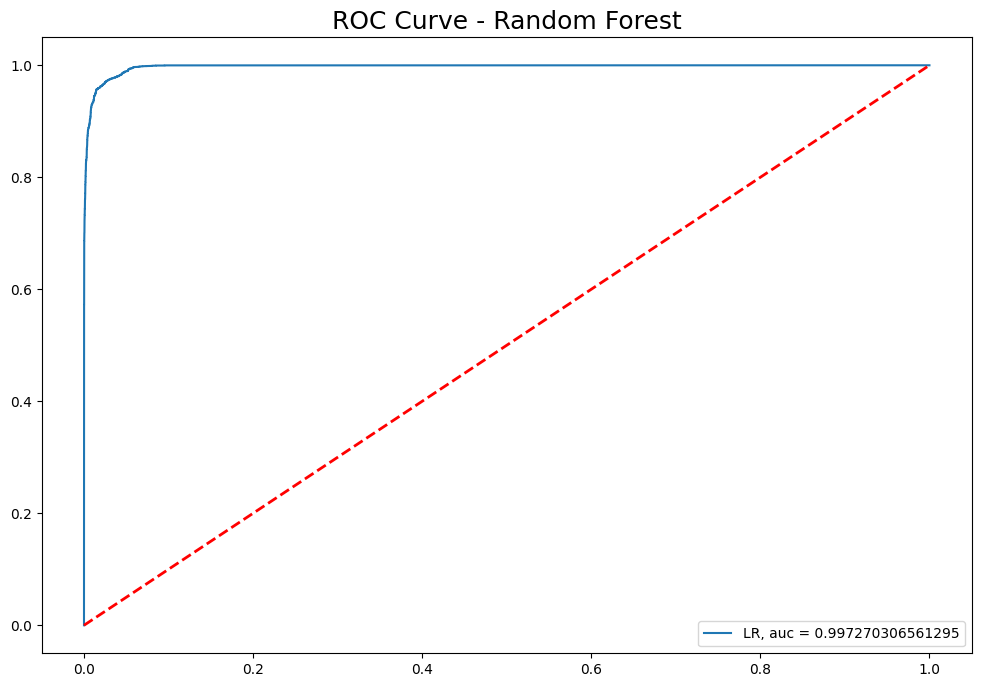

In [54]:
# instantiating ROC curve metrics
y_pred_proba = rf.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plotting
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)
plt.title('ROC Curve - Random Forest', fontsize = 18)

# Analyzing model's metrics

In [55]:
# models' list with its paremeters
classifiers = [
    LogisticRegression(max_iter = 1000, random_state = 42),
    DecisionTreeClassifier(max_depth = 5, random_state = 42),
    RandomForestClassifier(max_depth= 5, random_state = 42)]

LogisticRegression
***Results***
Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1 Score: 0.9428709521507975
DecisionTreeClassifier
***Results***
Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1 Score: 0.9632432017206943
RandomForestClassifier
***Results***
Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1 Score: 0.9723896175509079


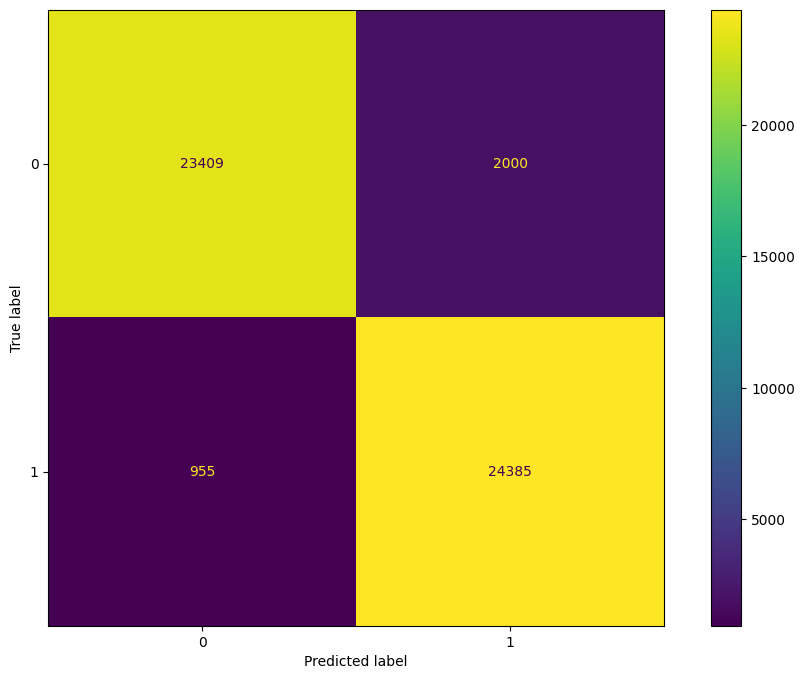

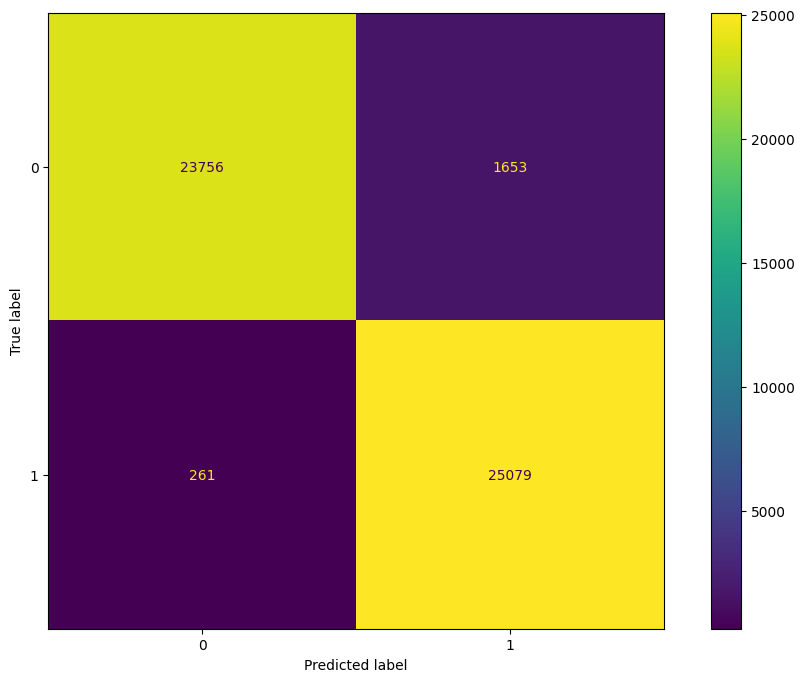

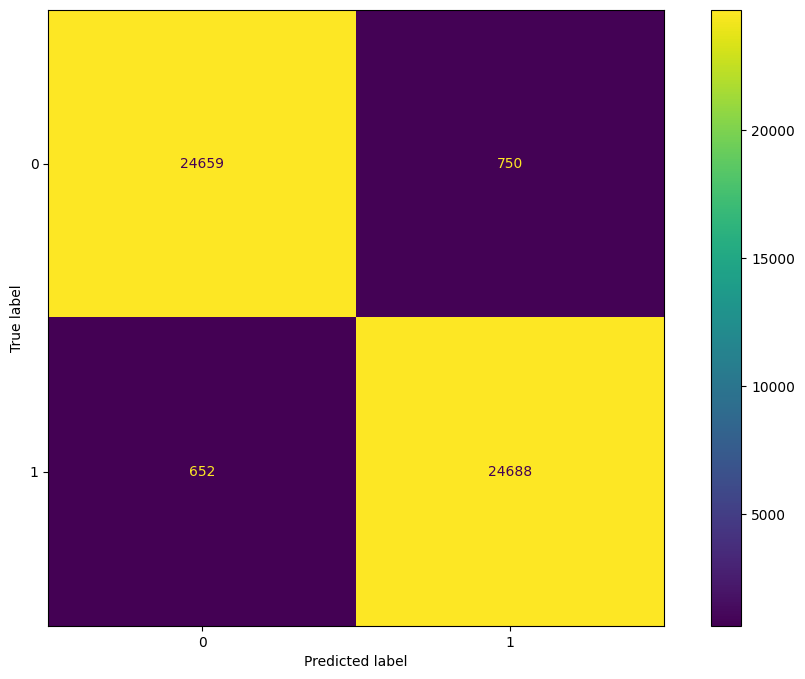

In [56]:
# loop to train the 3 models analyzed
for clf in classifiers:
    # training model
    clf.fit(x_train, y_train)
    # names of model for visualization
    name = clf.__class__.__name__
    print('='*30)
    print(name)
    print('***Results***')
    # predicting labels for each model
    y_pred = clf.predict(x_test)

    # metrics for each model
    # analyzing accuracy
    print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
    # analyzing precision
    print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
    # analyzing recall
    print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
    # analyzing F1 score
    print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

    # creating the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plotting confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()


The Random Forest algorithm performed the best result, the next step will be the improviment of its hyperparameters to achieve an even better result.

# Hyperparameter tuning

To discover the best hyperparameters for the model, it's necessary to vary them.

In [57]:
# range for n estimators varying from 20 to 2000 
n_estimators = np.arange(20, 2000, step = 20)
# criterions
criterion = ["gini", "entropy"]
# max_features types
max_features = ["auto", "sqrt", "log2"]
# varying depth of trees from 2 to 200
max_depth = list(np.arange(2, 200, step = 1))
# variying the min samples split from 2 to 100
min_samples_split = np.arange(2, 100, step = 2)
# varying the minime leaves' samples
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# bootstrap true or false
bootstrap = [True, False]

In [58]:
# dictionary with parameters to vary
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [59]:
# instantiating the chosen algorithm (random forest)
rforest = RandomForestClassifier(random_state = 75)

In [60]:
# hyperparameters on randomized search cv
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter = 5, cv = 3, scoring = "recall", n_jobs = -1, random_state = 75
)

In [61]:
# fitting
rcv = random_cv.fit(x, y)

KeyboardInterrupt: 

In [ ]:
# creating dataframe with hyperparameters' tests
tuning = pd.DataFrame(rcv.cv_results_)

In [ ]:
tuning

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,244.513878,18.616217,5.467070,0.215155,720,4,4,log2,120,entropy,True,"{'n_estimators': 720, 'min_samples_split': 4, ...",0.999320,0.999970,0.999734,0.999675,0.000269,1
1,180.025516,16.580329,5.297595,0.604610,600,16,2,sqrt,172,gini,True,"{'n_estimators': 600, 'min_samples_split': 16,...",0.999261,0.999941,0.999675,0.999626,0.000280,2
2,333.766674,26.037400,6.954162,0.589432,1080,34,1,sqrt,115,entropy,True,"{'n_estimators': 1080, 'min_samples_split': 34...",0.999261,0.999941,0.999616,0.999606,0.000278,3
3,530.506982,39.824027,8.107098,0.619066,1660,88,6,log2,52,entropy,False,"{'n_estimators': 1660, 'min_samples_split': 88...",0.999291,0.999941,0.999468,0.999566,0.000274,5
4,283.519081,19.133107,4.865599,0.383103,960,70,2,auto,100,entropy,False,"{'n_estimators': 960, 'min_samples_split': 70,...",0.999261,0.999941,0.999557,0.999586,0.000278,4


In [ ]:
# best parameters for the model
rcv.best_params_

{'n_estimators': 720,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 120,
 'criterion': 'entropy',
 'bootstrap': True}

Those are the best hyperparameters to maximize the recall metric.

# Aplying the best hyperparameters in Random Forest

In [ ]:
# instanntiating random forest
rfn = RandomForestClassifier(**rcv.best_params_, random_state = 75)

# training model
model = rfn.fit(x_train, y_train)
# predicted values
y_pred = rfn.predict(x_test)

# Final evaluation metrics

In [ ]:
# analyzing accuracy
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analyzing precision
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
# analyzing recall
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analyzing F1 score
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.9990935781985852
Precision: 0.99850216791486
Recall: 0.9996842936069456
F1 Score: 0.9990928810885427


# Random Forest confusion matrix for hyperparameter-tuned model

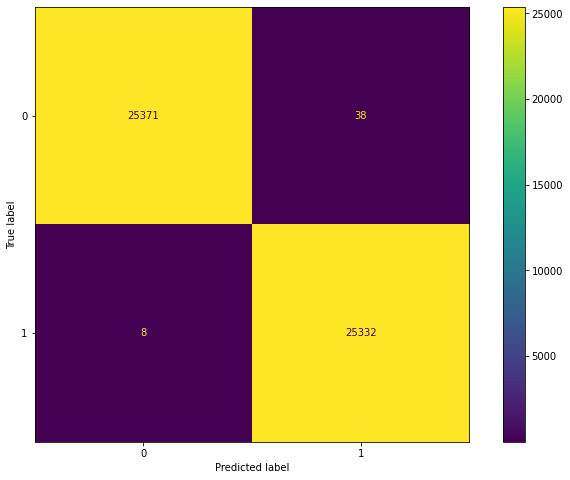

In [ ]:
# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Those are the best results achieved by our model and with this, the creation of a fraud detection system is possible.

# Solutions

* 1: The custommer has a certain pattern of money movement during business hours and the fraud occurs during other hours, such as night. Still in terms of time, the client can make his main transactions in an early period of the month and the fraud was seen on an unusual day.

Solution: - Using a CAPTHA system to increate security in unconventional hours.

* 2: The customer pays in cash as a default, either by PIX or cash withdrawal, and fraud can occur for a wire transfer payment.

- Solution: Request a verification of additional information from the bank, such as a security question, for transfer transactions.